## Discrete-time competitive Beverton-Holt model

\begin{align}
N_{1,t+1}=\dfrac{r_1N_{1,t}}{1+a_{11}N_{1,t}+a_{12}N_{2,t}} \\
N_{2,t+1}=\dfrac{r_2N_{2,t}}{1+a_{22}N_{2,t}+a_{21}N_{1,t}}
\tag{1}
\end{align}

## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('onedork') #grade3

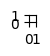

In [2]:
# Dummy plot
fig, ax = plt.subplots(figsize=(0.1, 0.1))
ax.axhline(y=1, color='grey', linestyle='-')
plt.rcParams.update({'font.size': 30})

[1.33013798 1.92431854]


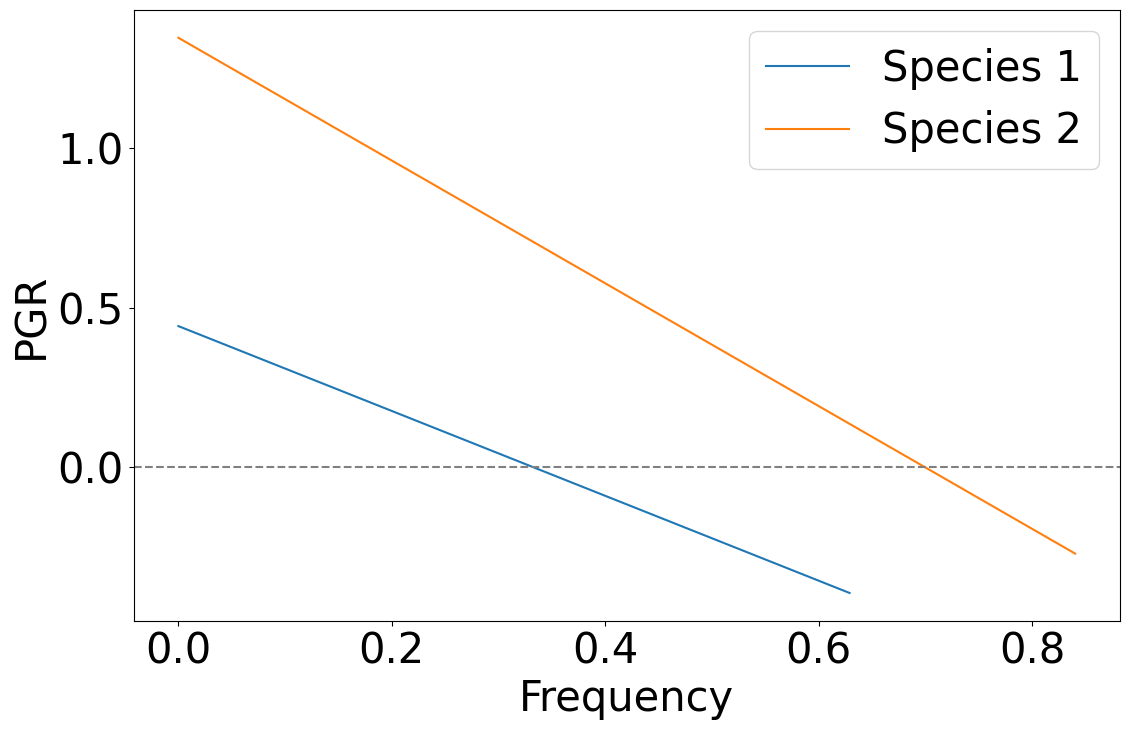

/tmp/ipykernel_15637/4220273134.py:35: RuntimeWarning: invalid value encountered in log
  out[0] = np.log(newN[0]) - np.log(N[0])  # per capita growth rate of species 1
/tmp/ipykernel_15637/4220273134.py:36: RuntimeWarning: invalid value encountered in log
  out[1] = np.log(newN[1]) - np.log(N[1])  # per capita growth rate of species 2


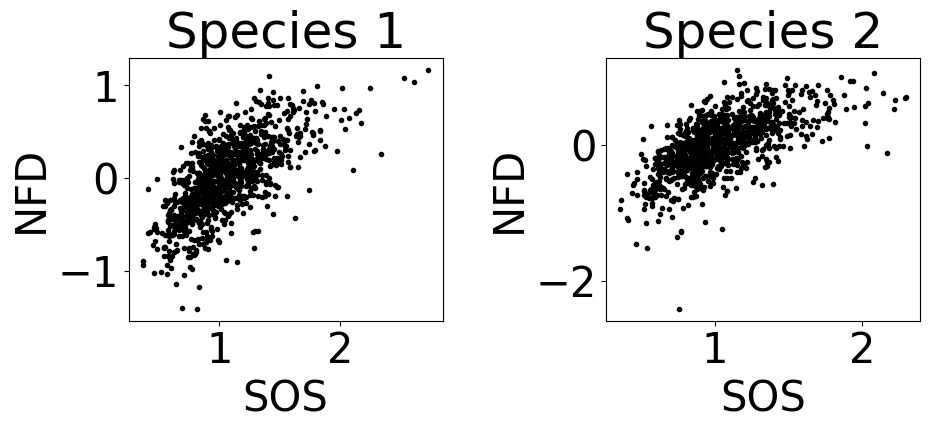

In [5]:
# This is a function to calculate negative frequency dependence
# for each species in a two species annual plant  model.
# You input the parameters (r's, alpha's) and it returns
# the growth rate of each species at very low density,
# the frequency of each species at low density,
# the growth rate at a slightly higher density,
# and the frequency at the higher density.

# Main note: When I increase the growth rate of species 1 
# a little above low density, I set species 2 at its equilibrium
# density, given the "fixed" density of species 1.

# For comparison, I also included the function we used in the paper.


# FUNCTIONS ----------------------------------------------------

# strength of stabilization as measured in our paper
def SOS(r, alpha):
    out = np.empty(2)
    out[0] = r[1] / (1 + (alpha[0][1] / alpha[1][1]) * (r[1] - 1))
    out[1] = r[0] / (1 + (alpha[1][0] / alpha[0][0]) * (r[0] - 1))
    return out


# calculate log per capita growth rate
def getPCG(r, alpha, N):
    # r is a list of fecundities for spp 1 and 2
    # alpha is a matrix of interaction coefficients where alpha[i][j] is the effect of j on i
    # N is a list of densities for spp 1 and 2
    newN = np.empty(2)
    newN[0] = r[0] * N[0] / (1 + alpha[0][0] * N[0] + alpha[0][1] * N[1])
    newN[1] = r[1] * N[1] / (1 + alpha[1][0] * N[0] + alpha[1][1] * N[1])
    out = np.empty(2)
    out[0] = np.log(newN[0]) - np.log(N[0])  # per capita growth rate of species 1
    out[1] = np.log(newN[1]) - np.log(N[1])  # per capita growth rate of species 2
    return out


# figure out the equilibrium density of the focal species' competitor
# given a fixed density of the focal species
def getEqDensity(species, r, alpha, N_star):
    # species = focal species (this one is fixed, density of the other is returned)
    # N_start (a scalar) is the density of the fixed spp
    if species == 1:
        # density of species zero is known
        out = (r[1] - 1 - alpha[1][0] * N_star) / alpha[1][1]
    elif species == 2:
        # density of species one is known
        out = (r[0] - 1 - alpha[0][1] * N_star) / alpha[0][0]
    return out

def getNFD(r, alpha, lowN, deltaN):
    # lowN is the low density 
    # and deltaN is the increase in N for the higher density to explore

    # vectors for output
    pgr1, freq1, pgr2, freq2 = [None]*2, [None]*2, [None]*2, [None]*2

    # get low density growth rate for spp 1
    tmpN = [None]*2
    tmpN[0] = lowN  # set density of focal spp
    tmpN[1] = getEqDensity(species=1, r=r, alpha=alpha, N_star=tmpN[0])  # figure out density of its competitor
    tmpOut = getPCG(r=r, alpha=alpha, N=tmpN)
    pgr1[0] = tmpOut[0]
    freq1[0] = tmpN[0] / np.sum(tmpN)

    # get low density growth rate for spp 2
    tmpN = [None]*2
    tmpN[1] = lowN
    tmpN[0] = getEqDensity(species=2, r=r, alpha=alpha, N_star=tmpN[1])
    tmpOut = getPCG(r=r, alpha=alpha, N=tmpN)
    pgr1[1] = tmpOut[1]
    freq1[1] = tmpN[1] / np.sum(tmpN)

    # get higher density growth rate for spp1 1
    tmpN = [None]*2
    tmpN[0] = lowN + deltaN
    tmpN[1] = getEqDensity(species=1, r=r, alpha=alpha, N_star=tmpN[0])
    tmpOut = getPCG(r=r, alpha=alpha, N=tmpN)
    pgr2[0] = tmpOut[0]
    freq2[0] = tmpN[0] / np.sum(tmpN)

    # get higher density growth rate for spp1 2
    tmpN = [None]*2
    tmpN[1] = lowN + deltaN
    tmpN[0] = getEqDensity(species=2, r=r, alpha=alpha, N_star=tmpN[1])
    tmpOut = getPCG(r=r, alpha=alpha, N=tmpN)
    pgr2[1] = tmpOut[1]
    freq2[1] = tmpN[1] / np.sum(tmpN)

    return {'pgr1': pgr1, 'freq1': freq1, 'pgr2': pgr2, 'freq2': freq2}


# example use --------------------------------------------------------

r = np.array([100, 80])
alpha = np.array([[1, 0.8], [0.2, 1]])
lowN = 0.001
deltaN = 100 

r1=r[0]
r2=r[1]
a11=alpha[0][0]
a12=alpha[0][1]
a21=alpha[1][0]
a22=alpha[1][1]

test = getNFD(r, alpha, lowN, deltaN)

pgr1=np.array(test['pgr1'])
pgr2=np.array(test['pgr2'])
freq1=np.array(test['freq1'])
freq2=np.array(test['freq2'])

print(-1 * (pgr2 - pgr1) / (freq2 - freq1) )

# calculate Yenni et al. 2012 SOS
#print(SOS(r, alpha))  # compare to what we used in the paper

# take a look
fig, (ax) = plt.subplots(1,figsize=(12, 8))
plt.plot(np.vstack((test['freq1'],test['freq2'])),np.vstack((test['pgr1'],test['pgr2'])), label=['Species 1', 'Species 2'])
plt.axhline(y=0, color='grey', linestyle='--')
plt.xlabel('Frequency')
plt.ylabel('PGR')
plt.legend()
plt.tight_layout()
plt.savefig('img/frequency_PGR_r1_'+str(np.around(r1,1))+'_r2_'+str(np.around(r2,1))+'_a11_'+str(np.around(a11,1))+'_a12_'+str(np.around(a12,1))+'_a21_'+str(np.around(a21,1))+'_a22_'+str(np.around(a22,1))+'.png', format='png', dpi=50)
plt.show()

# Compare SOS and NFD for 1000 random parameter sets
compareRandom = pd.DataFrame({'SOS1': np.nan, 'SOS2': np.nan, 'NFD1': np.nan, 'NFD2': np.nan}, index=range(1000))

for i in range(1000):
    r = np.random.normal(100, 10, 2)
    alpha = np.random.normal(1, 0.2, 4).reshape(2, 2)
    SOS1, SOS2 = SOS(r, alpha)
    compareRandom.loc[i, 'SOS1'] = SOS1
    compareRandom.loc[i, 'SOS2'] = SOS2
    test = getNFD(r, alpha, lowN, deltaN)
    
    if test['freq2'][0] - test['freq1'][0] == 0:
        compareRandom.loc[i, 'NFD1'] = np.nan
    else:
        compareRandom.loc[i, 'NFD1'] = -1 * (test['pgr2'][0] - test['pgr1'][0]) / (test['freq2'][0] - test['freq1'][0])
    
    if test['freq2'][1] - test['freq1'][1] == 0:
        compareRandom.loc[i, 'NFD2'] = np.nan
    else:
        compareRandom.loc[i, 'NFD2'] = -1 * (test['pgr2'][1] - test['pgr1'][1]) / (test['freq2'][1] - test['freq1'][1])
        
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(compareRandom['SOS1'], compareRandom['NFD1'], 'ko', markersize=3)
plt.xlabel('SOS')
plt.ylabel('NFD')
plt.title('Species 1')

plt.subplot(122)
plt.plot(compareRandom['SOS2'], compareRandom['NFD2'], 'ko', markersize=3)
plt.xlabel('SOS')
plt.ylabel('NFD')
plt.title('Species 2')
plt.tight_layout()
plt.show()